In [100]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [101]:
# this_dir = os.path.dirname(os.path.abspath(__file__))
ECG_path = os.path.join("ECGData.mat")

ECG_data = sio.loadmat(ECG_path)

ECG_signal = np.double(ECG_data["m_Data"][0])[44000:55000]
sample_rate = ECG_data["s_Freq"][0][0]
sample_period = 1 / sample_rate
time_array = np.arange(np.size(ECG_signal)) / sample_rate  # Time values
time_array = np.array(time_array)

In [102]:
initial_freq = 0
test_freq_lt = []
for i in range(len(ECG_signal)):
    freq = i * (sample_rate / len(ECG_signal))
    test_freq_lt.append(float(freq))

In [103]:
fft_results = np.zeros(np.size(test_freq_lt), dtype=complex)

for i in tqdm(range(len(test_freq_lt))):
    x_test = np.exp(-1j * 2.0 * np.pi * test_freq_lt[i] * time_array)
    x_test = np.flip(x_test)

    fft_results[i] = np.convolve(
        ECG_signal, np.real(x_test), "valid"
    ) + 1j * np.convolve(ECG_signal, np.imag(x_test), "valid")

  0%|          | 0/11000 [00:00<?, ?it/s]C:\Users\tobon\AppData\Local\Temp\ipykernel_9624\1409849739.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fft_results[i] = np.convolve(
100%|██████████| 11000/11000 [00:12<00:00, 857.75it/s]


In [104]:
fft_gt = np.fft.fft(ECG_signal)

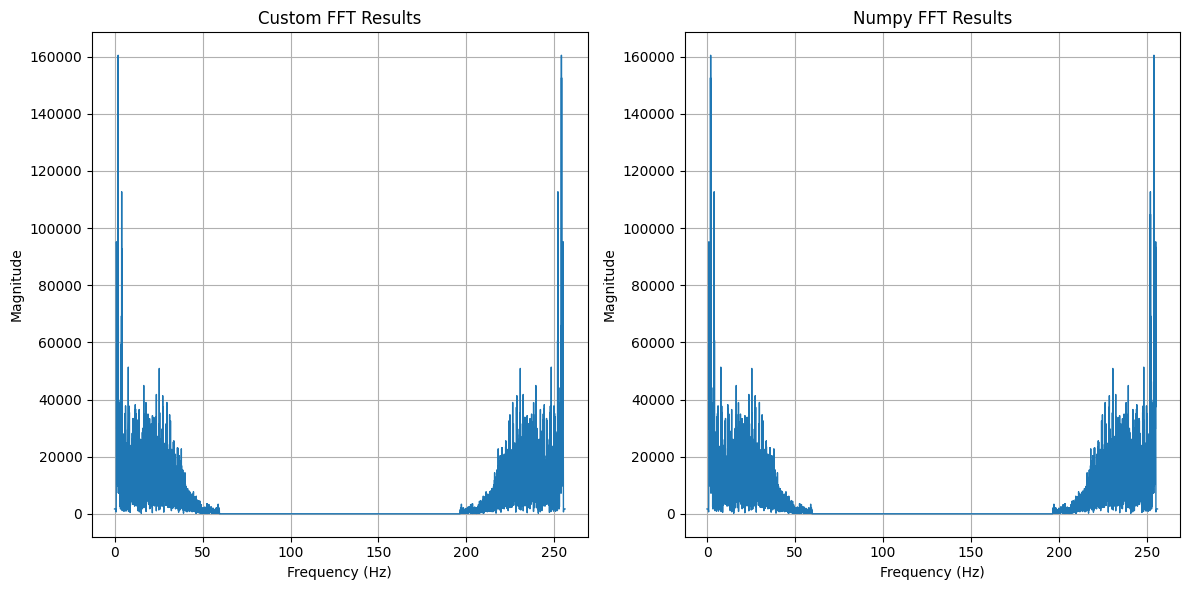

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(test_freq_lt, np.abs(fft_results), linewidth=1)
axs[0].set_title("Custom FFT Results")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Magnitude")
axs[0].grid(True)

axs[1].plot(test_freq_lt, np.abs(fft_gt), linewidth=1)
axs[1].set_title("Numpy FFT Results")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Magnitude")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [106]:
min_freq = 0.8
max_freq = 35

filtered_results = np.copy(np.array(fft_results))

for i in range(len(test_freq_lt)):
    if test_freq_lt[i] < min_freq or test_freq_lt[i] > max_freq:
        filtered_results[i] = 0

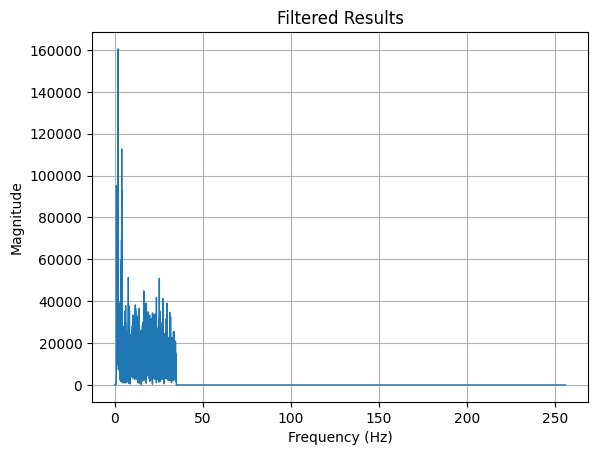

In [107]:
plt.figure()
plt.plot(test_freq_lt, np.abs(filtered_results), linewidth=1)
plt.title("Filtered Results")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)

In [108]:
ifft_results = np.zeros(np.size(filtered_results), dtype=complex)
for i in tqdm(range(len(filtered_results))):
    x_test = np.exp(1j * 2.0 * np.pi * test_freq_lt[i] * time_array)
    x_test = np.flip(x_test)

    ifft_results[i] = np.convolve(
        filtered_results, np.real(x_test), "valid"
    ) + 1j * np.convolve(filtered_results, np.imag(x_test), "valid")

ifft_results = (1 / len(ifft_results)) * ifft_results

  0%|          | 0/11000 [00:00<?, ?it/s]C:\Users\tobon\AppData\Local\Temp\ipykernel_9624\583241162.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ifft_results[i] = np.convolve(
100%|██████████| 11000/11000 [00:12<00:00, 852.38it/s]


In [109]:
ifft_gt = np.fft.ifft(filtered_results)

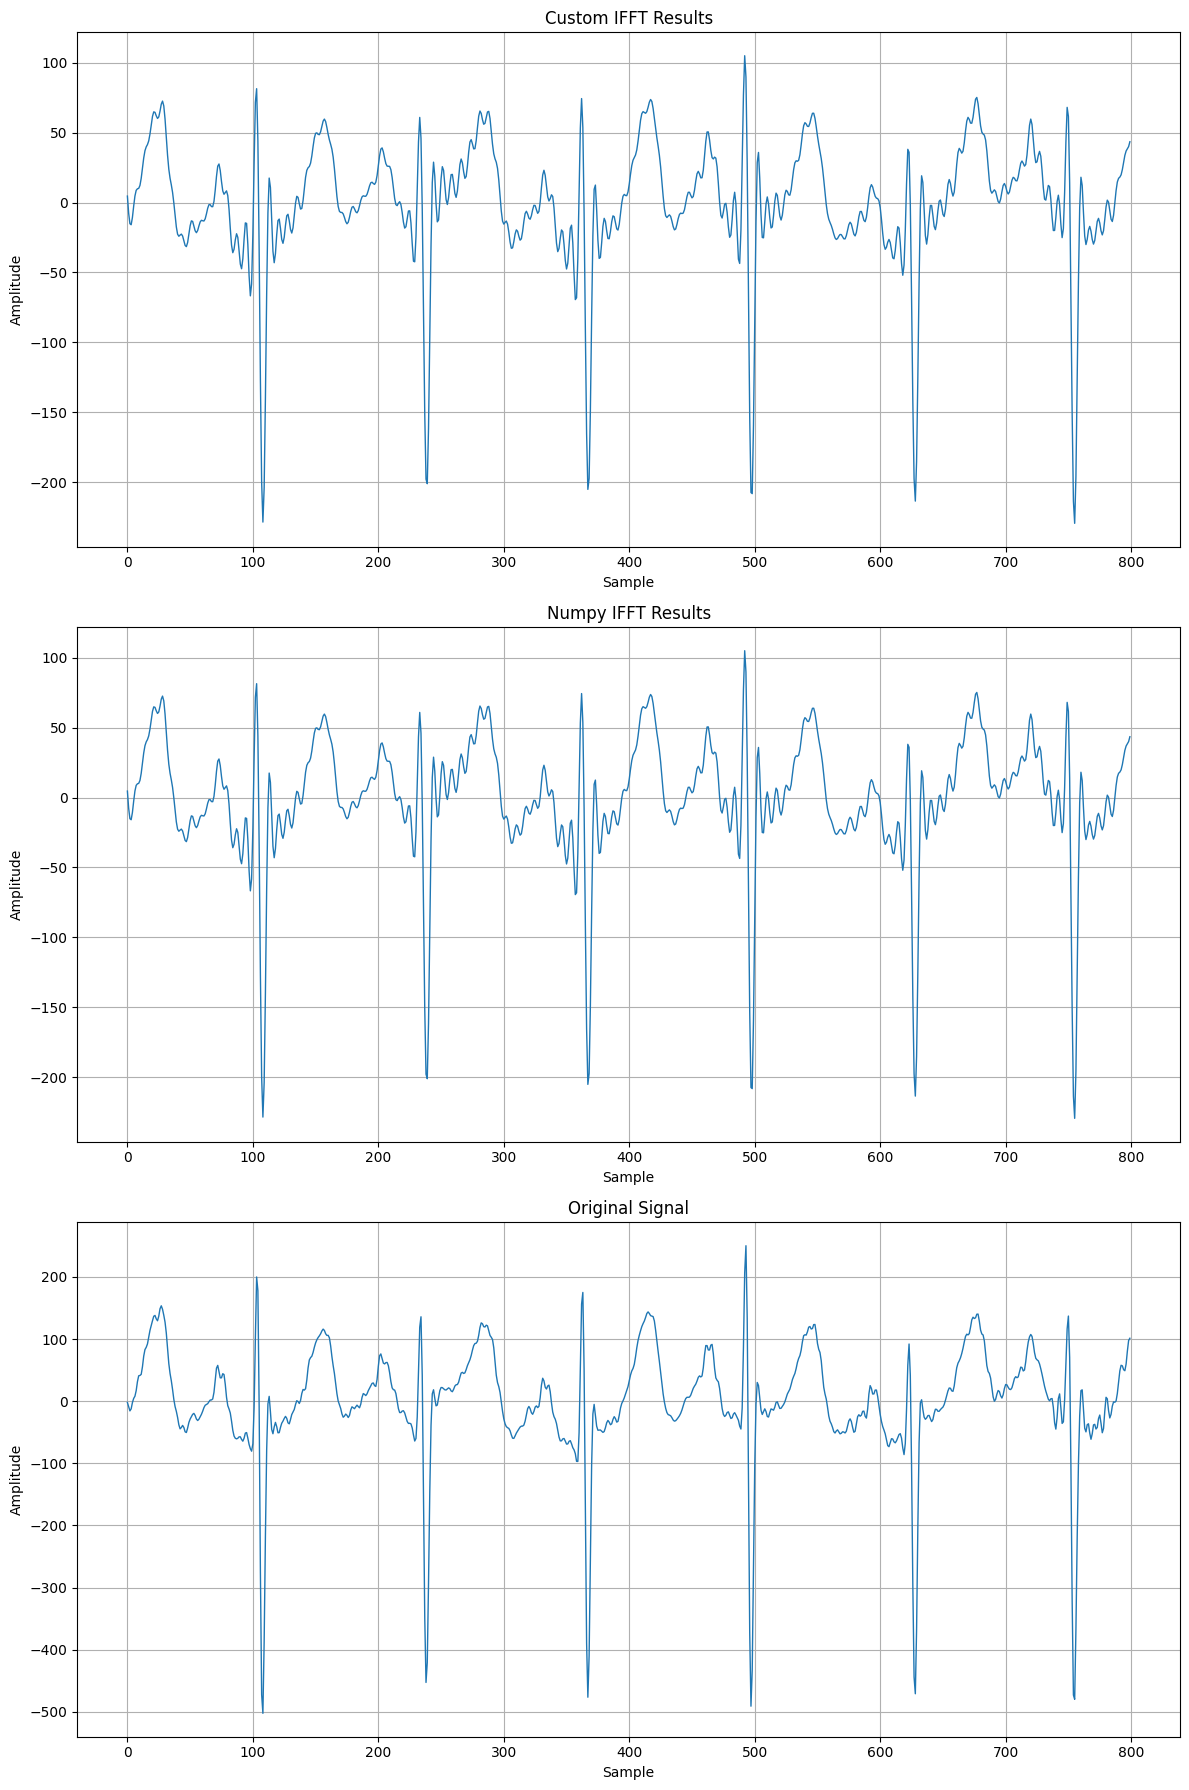

In [110]:
data_len = 800
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].plot(np.real(ifft_results[:data_len]), linewidth=1)
axs[0].set_title("Custom IFFT Results")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True)

axs[1].plot(np.real(ifft_gt[:data_len]), linewidth=1)
axs[1].set_title("Numpy IFFT Results")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Amplitude")
axs[1].grid(True)

axs[2].plot(ECG_signal[:data_len], linewidth=1)
axs[2].set_title("Original Signal")
axs[2].set_xlabel("Sample")
axs[2].set_ylabel("Amplitude")
axs[2].grid(True)

plt.tight_layout()
plt.show()

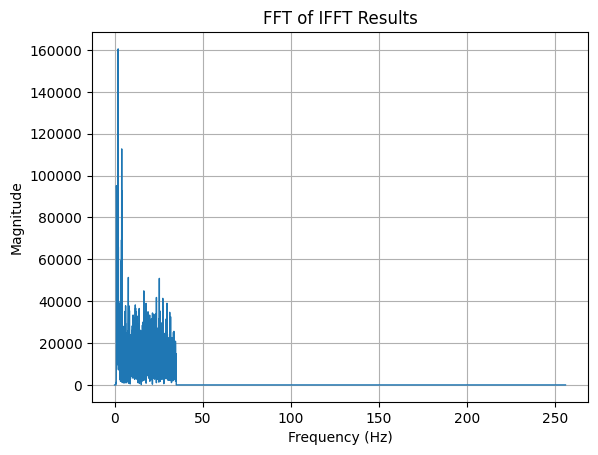

In [111]:
fft_gt = np.fft.fft(ifft_results)
plt.figure()
plt.plot(test_freq_lt, np.abs(fft_gt), linewidth=1)
plt.title("FFT of IFFT Results")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

In [112]:
def derivate_and_squaring(signal):
    for i in range(len(signal) - 1):
        signal[i] = (signal[i + 1] - signal[i]) ** 2
    return signal[:-1]

In [113]:
def moving_window_integration(signal, sample_period, window_size=0.06):
    half_window = window_size / 2

    n_samples_in_half_window = int(half_window / sample_period)

    output_signal = np.zeros(len(signal))

    for i in range(len(signal)):
        start_idx = i - n_samples_in_half_window
        end_idx = i + n_samples_in_half_window

        if start_idx < 0:
            start_idx = 0
        if end_idx >= len(signal):
            end_idx = len(signal) - 1

        output_signal[i] = np.mean(signal[start_idx:end_idx])

    return output_signal

In [114]:
filtered_signal = np.abs(ifft_results)

In [115]:
base_signal = np.copy(np.real(filtered_signal))

diff_signal = derivate_and_squaring(base_signal)

integrated_signal = moving_window_integration(
    diff_signal, sample_period, window_size=0.06
)

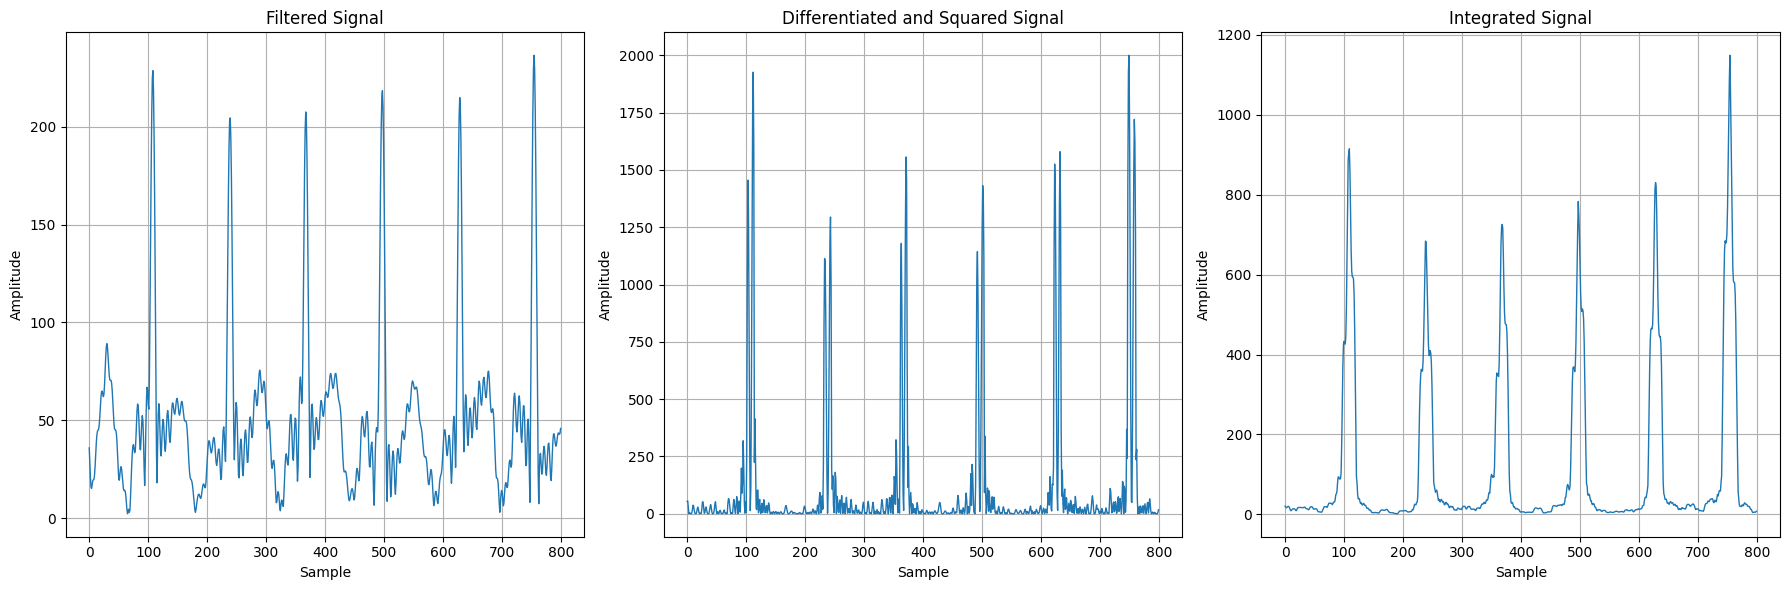

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot((filtered_signal[:data_len]), linewidth=1)
axs[0].set_title("Filtered Signal")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True)

axs[1].plot((diff_signal[:data_len]), linewidth=1)
axs[1].set_title("Differentiated and Squared Signal")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Amplitude")
axs[1].grid(True)

axs[2].plot((integrated_signal[:data_len]), linewidth=1)
axs[2].set_title("Integrated Signal")
axs[2].set_xlabel("Sample")
axs[2].set_ylabel("Amplitude")
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [123]:
def detect_peaks(signal, window_size, threshold):
    peak_values = []
    peaks_idxs = []

    first_peak_found = False
    search_idx = 0
    start_idx = 0
    while (not first_peak_found) and (search_idx < len(signal)):
        window = signal[search_idx : search_idx + window_size]
        window_max = np.max(window)
        if window_max > threshold:
            first_peak_found = True
            peak_values.append(window_max)
            peaks_idxs.append(search_idx + np.argmax(window))
            start_idx = search_idx + (window_size // 2)
        else:
            search_idx += window_size

    for i in range(start_idx, len(signal), window_size):
        window = signal[i : i + window_size]
        window_max = np.max(window)
        if window_max > threshold:
            peak_values.append(window_max)
            peaks_idxs.append(i + np.argmax(window))
    return peak_values, peaks_idxs

In [124]:
peak_values, peak_idxs = detect_peaks(integrated_signal, window_size=120, threshold=600)

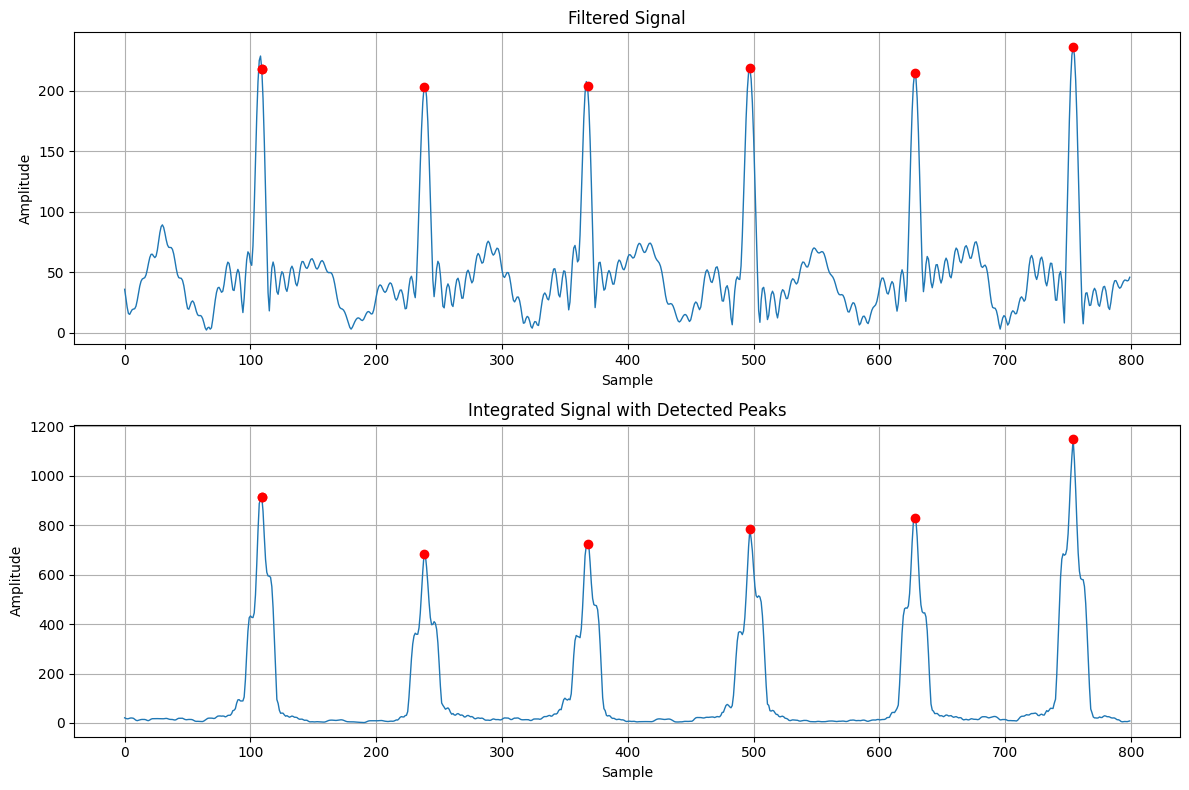

In [125]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Plot filtered signal
axs[0].plot(np.real(filtered_signal[:data_len]), linewidth=1)
axs[0].set_title("Filtered Signal")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True)

# Plot peaks on filtered signal
for peak_value, peak_idx in zip(peak_values, peak_idxs):
    if peak_idx < data_len:
        axs[0].plot(peak_idx, np.real(filtered_signal[peak_idx]), 'ro')

# Plot integrated signal with detected peaks
axs[1].plot(integrated_signal[:data_len], linewidth=1)
axs[1].set_title("Integrated Signal with Detected Peaks")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Amplitude")
axs[1].grid(True)

# Plot peaks on integrated signal
for peak_value, peak_idx in zip(peak_values, peak_idxs):
    if peak_idx < data_len:
        axs[1].plot(peak_idx, integrated_signal[peak_idx], 'ro')

plt.tight_layout()
plt.show()